<a href="https://colab.research.google.com/github/Pumafi/flumy-wgan-mines/blob/main/Mixture_3D_cov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun 20 08:46:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [ ]:
import sys
sys.path.append('..')

# From the git
from models.conditional_generation.gaussian_mixture_3d import Mixture, train_inference_network
from utils.visualisation import *
from utils.visualisation_conditioning import *
from data.load_data import get_3d_flumy_data, load_data, ConditionalDataGenerator3D
from models.load_trained_models import load_msgen_horizontal, wgan_horizontal,\
    load_msnwgen_2d_gs_horizontal, load_wgan_gs_horizontal, load_mswgen_sn_3d_horizontal
from utils.utils import generate_noise, correct_percentage_3d

In [3]:
from tensorflow import keras
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Conditioning utilities
from scipy.stats import kde
from keras.utils.np_utils import to_categorical
from sklearn.metrics.pairwise import euclidean_distances

# Suplementary tf options
tf.config.run_functions_eagerly(True)

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Loading the Model

In [4]:
# Creating the 3D Generator Model
g_model = load_mswgen_sn_3d_horizontal("./trainedweights/mswgen3d/cp-gen2d_horizontal_good.ckpt")
g_model.summary()

Model: "multi_scale_generator3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial (Generato  multiple                 7168      
 rInitial)                                                       
                                                                 
 generator_block (GeneratorB  multiple                 1327876   
 lock)                                                           
                                                                 
 generator_block_1 (Generato  multiple                 332164    
 rBlock)                                                         
                                                                 
 generator_block_2 (Generato  multiple                 83140     
 rBlock)                                                         
                                                                 
 last_generator_block (LastG  multiple     

### Flumy Condtional 3D data Generator

In [9]:
slice_size = (16, 32, 64, 4)
noise_shape = (2, 4, 8, 1)
input_shape = (2, 4, 8, 1)

In [10]:
import os
import io
import requests
import zipfile
import pandas as pd

def get_3d_flumy_data():
    filename = "./data/3D/dataFlumy3D.csv"
    data_file = './data/3D'
    dataset = "./data/3D/dataFlumy3D.csv"

    if not os.path.exists(data_file):
        os.mkdir(data_file)

    # Download data
    if not os.path.exists(dataset):
        r = requests.get("https://cloud.mines-paristech.fr/index.php/s/G4l6fHfMhWOucyj/download?path=%2F&files"
                         "=dataFlumy3D_20slices_3000img.csv.zip")
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(data_file)
        # open(dataset, 'wb').write(r.content)

    data = pd.read_csv(filename, sep=',').values
    print(data.shape)
    data = data[:, :30]
    print(data.shape)
    data = data.transpose(1, 0)
    print(data.shape)

    data = data.reshape((-1, 20, 64, 128)) - 1
    #x_train = np.swapaxes(x_train.astype('int32'), 0, -1)
    return data

In [11]:
x_generated = get_3d_flumy_data()[:20, :16, :32, :64]
x_generated = to_categorical(x_generated, num_classes=4)
x_generated.shape

(163840, 3000)
(163840, 30)
(30, 163840)


(20, 16, 32, 64, 4)

In [13]:
nb_wells = 5

dataloader = ConditionalDataGenerator3D(x_generated, 1, slice_size, wells=nb_wells, mode=0)
x, msk, y = dataloader.__getitem__(0)
print(x.shape, msk.shape, y.shape)

(1, 16, 32, 64, 4) (1, 16, 32, 64, 1) (1, 16, 32, 64, 4)


## Models and training

### Model Training

In [16]:
npart = 10

tf.random.set_seed(222)
a = Mixture(npart = npart)

In [17]:

epochs=8500
history = {"Total Loss": [], "Negative Entropy": [], "Cross Loss": []}
optimiser = train_inference_network(a, g_model, x, msk, history,
                                  epochs=epochs, batch_size=350,lr =0.0005)



  0%|          | 0/8500 [00:00<?, ?it/s]

### Training Curves

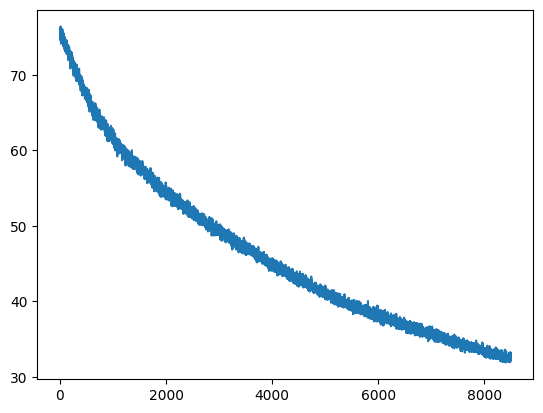

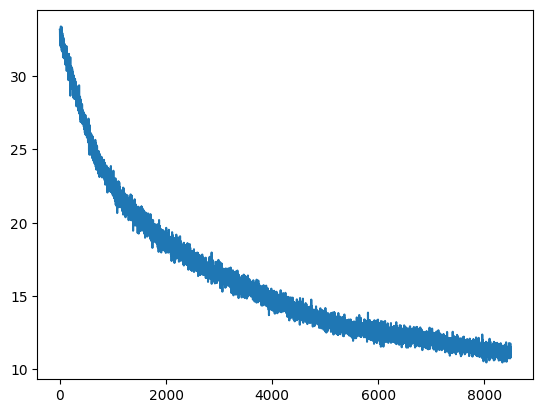

In [18]:
x_axis = np.arange(len(history["Total Loss"]))
plt.plot(x_axis, history["Total Loss"])
plt.show()
x_axis = np.arange(len(history["Cross Loss"]))
plt.plot(x_axis, history["Cross Loss"])
plt.show()

## Results

In [19]:
z_original = tf.random.normal(shape=(100, *noise_shape))
z, _, _ = a(z_original)
z.shape
generated_images = g_model(z)[-1]
correct_percentage_3d(generated_images, y, msk, print_res=True)

Percentage of successful predictions 90.90%:


90.9

In [20]:
generated_images.shape

TensorShape([100, 16, 32, 64, 4])

In [21]:
cmap, norm = get_color_map(number_of_categories=4)

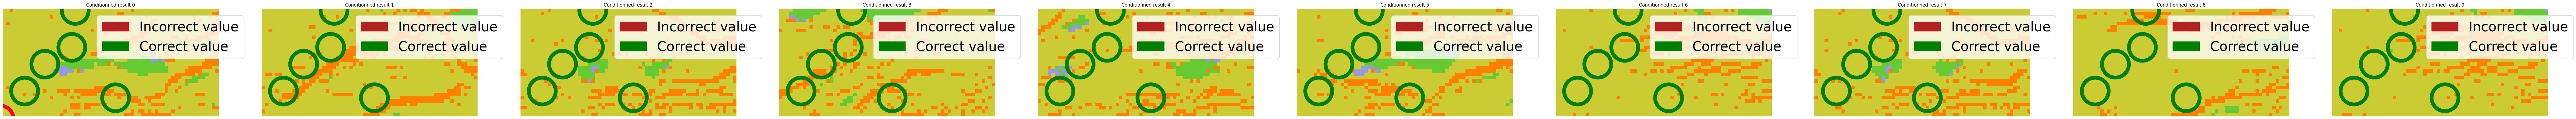

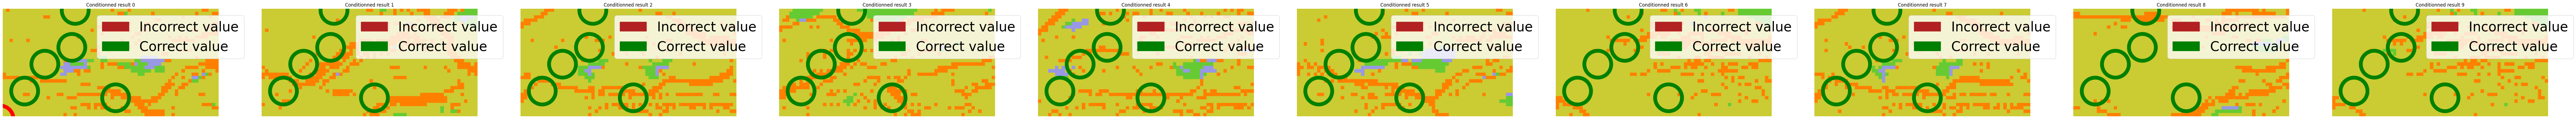

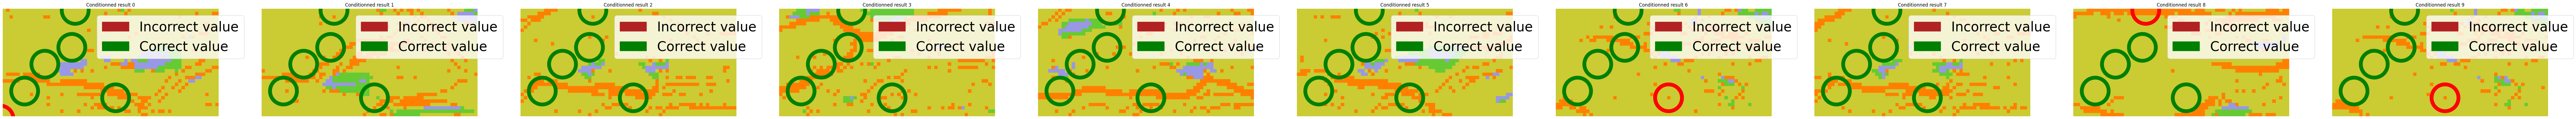

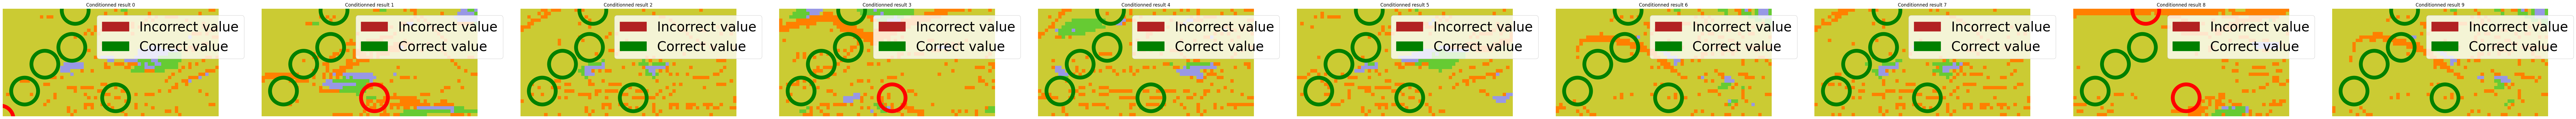

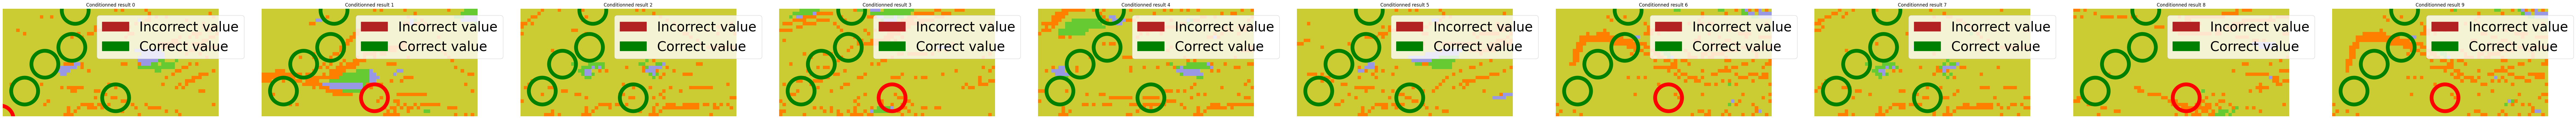

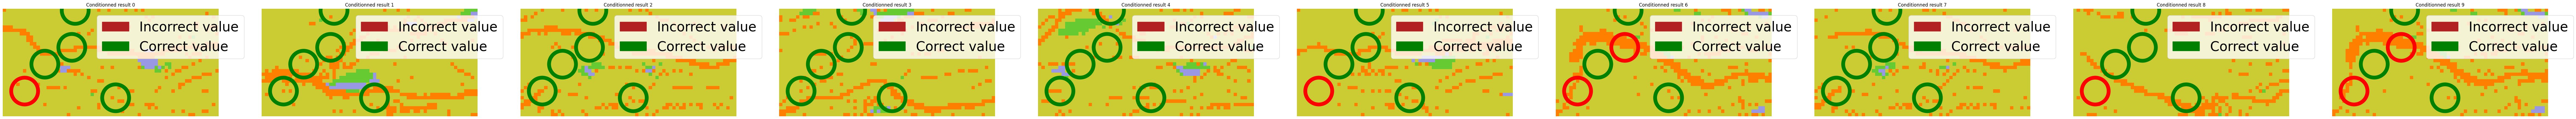

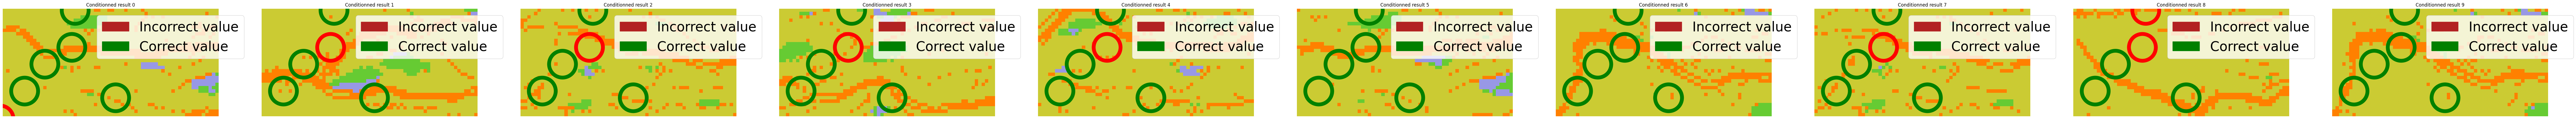

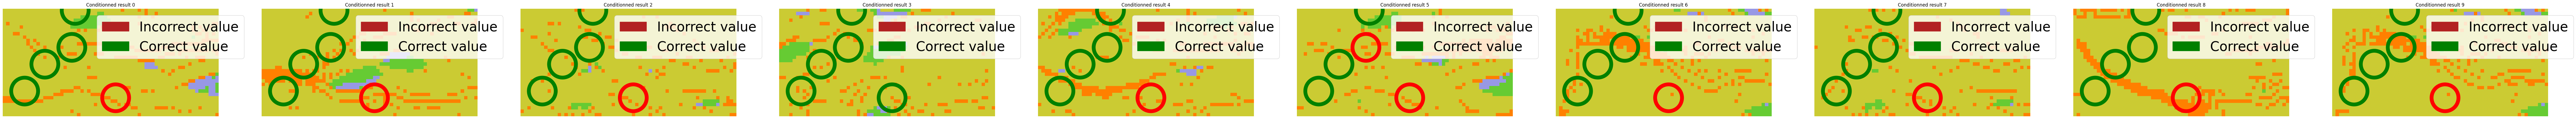

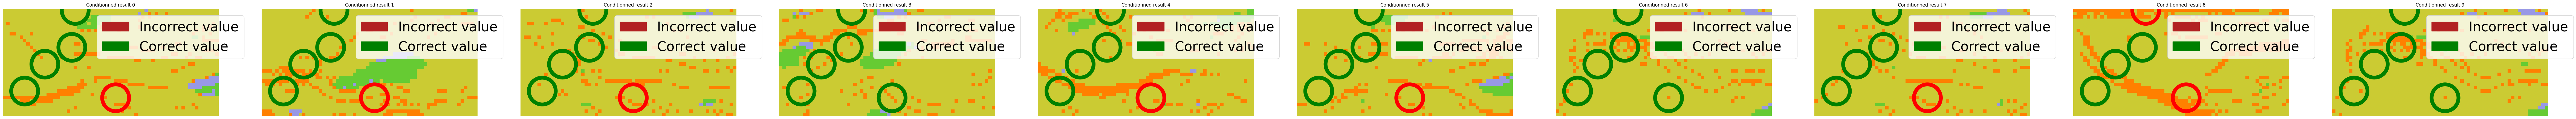

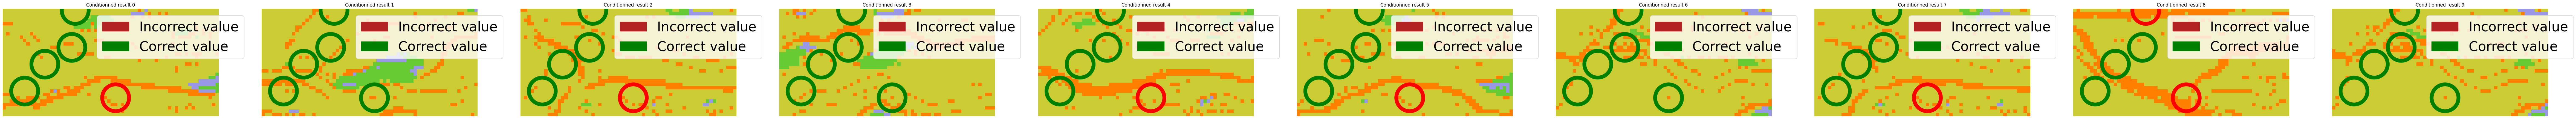

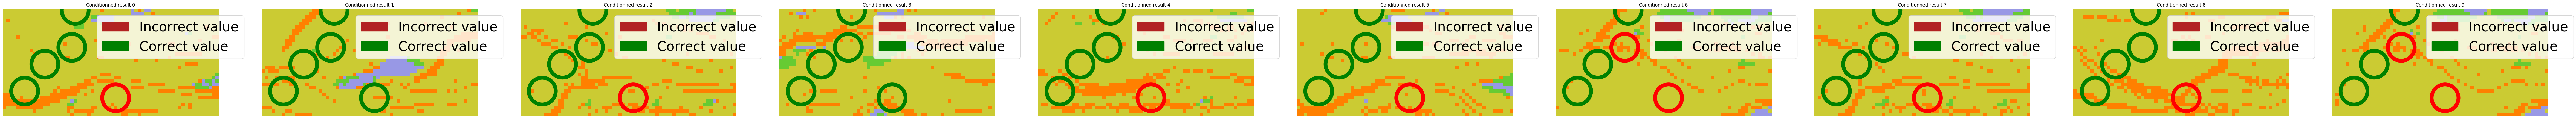

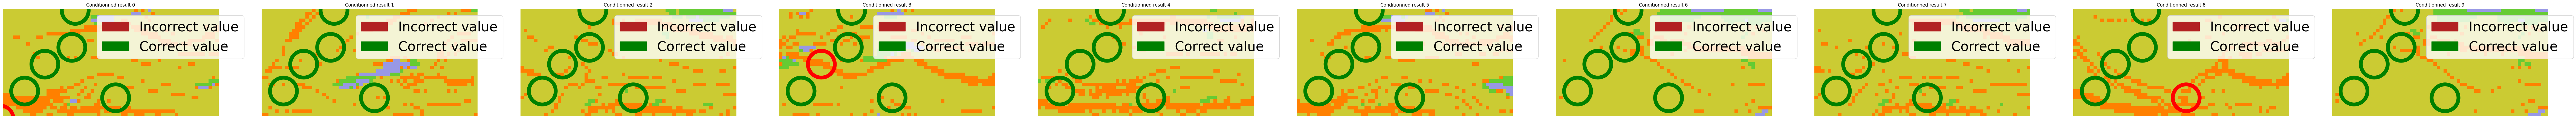

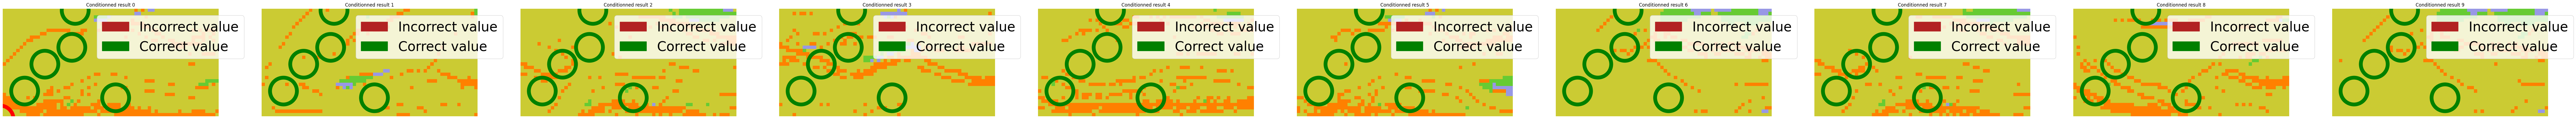

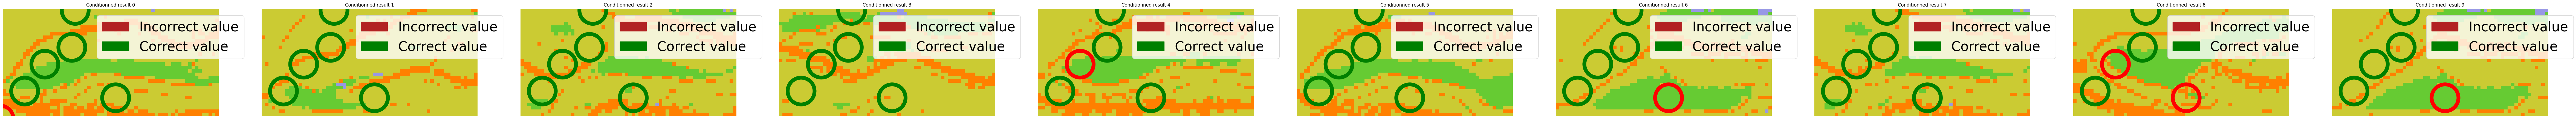

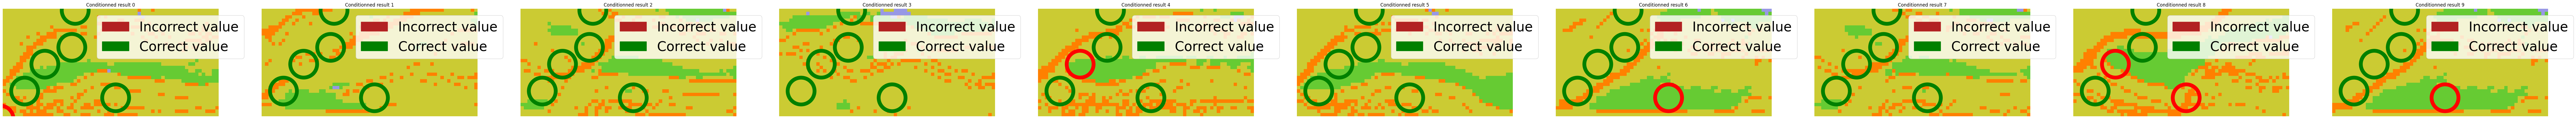

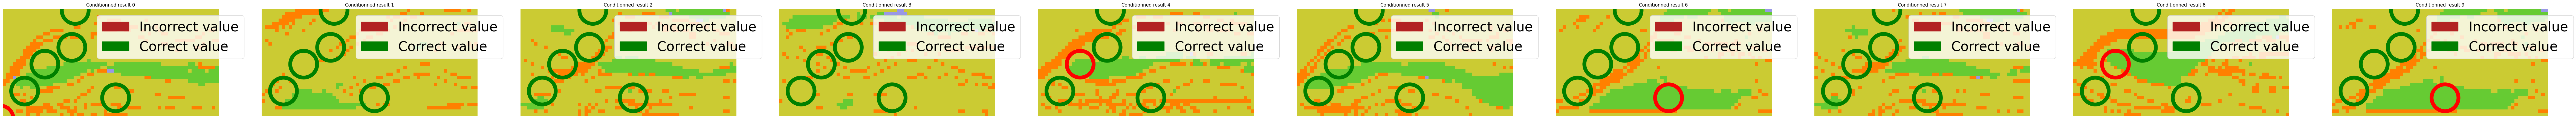

In [22]:
for i in range(16):
  slice_generated_images = generated_images[:, i]
  mski = np.expand_dims(msk[0, i], axis=0)
  xi = np.expand_dims(x[0, i], axis=0)
  print_conditioned_results(xi, slice_generated_images, mski, 10, cmap, norm, slice_size=(slice_size[1], slice_size[2]))
  #visualise_slice(generated_images_i, cmap, norm, 32, 64)



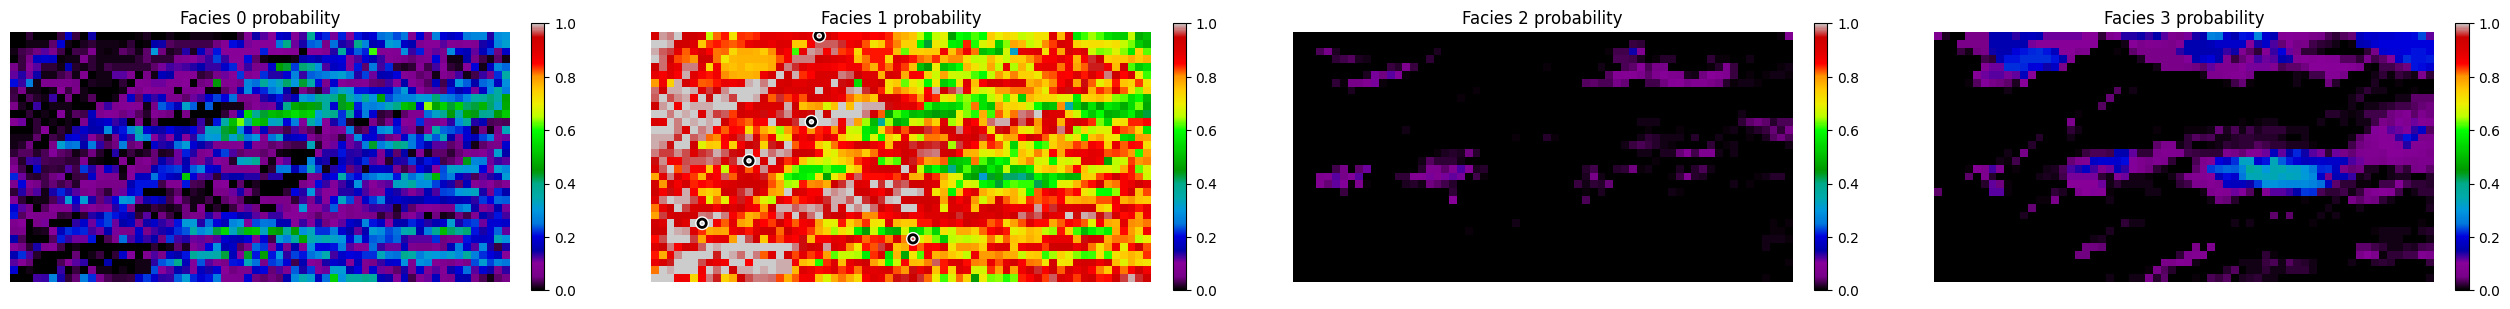

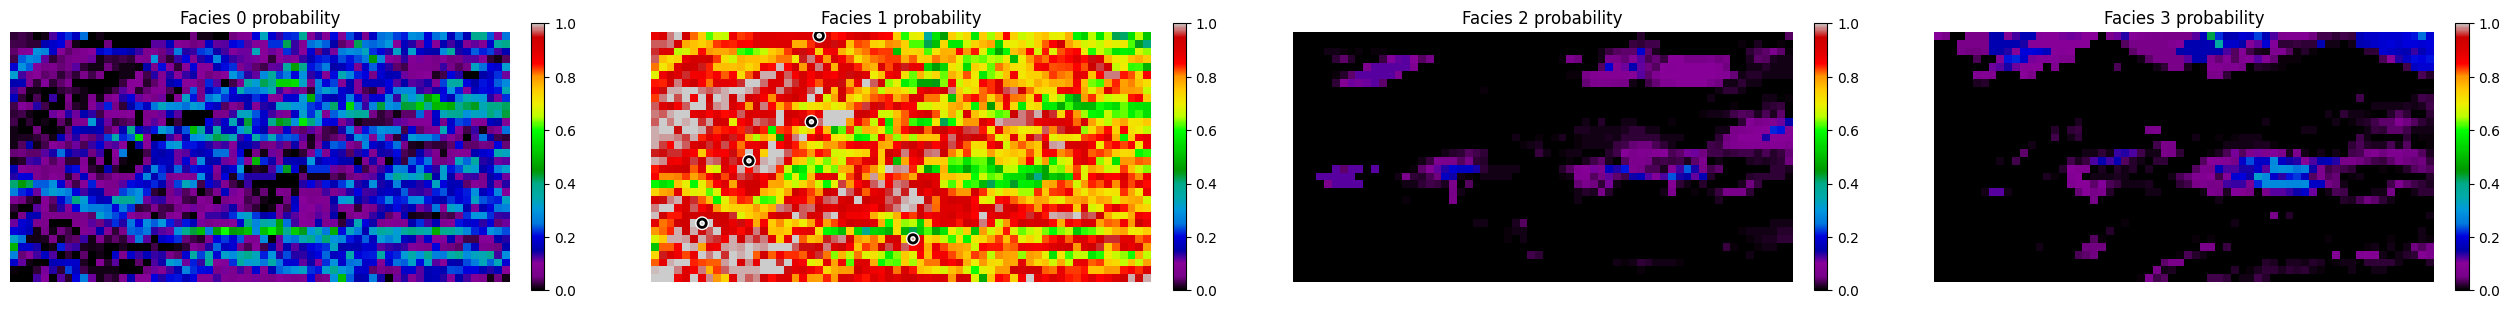

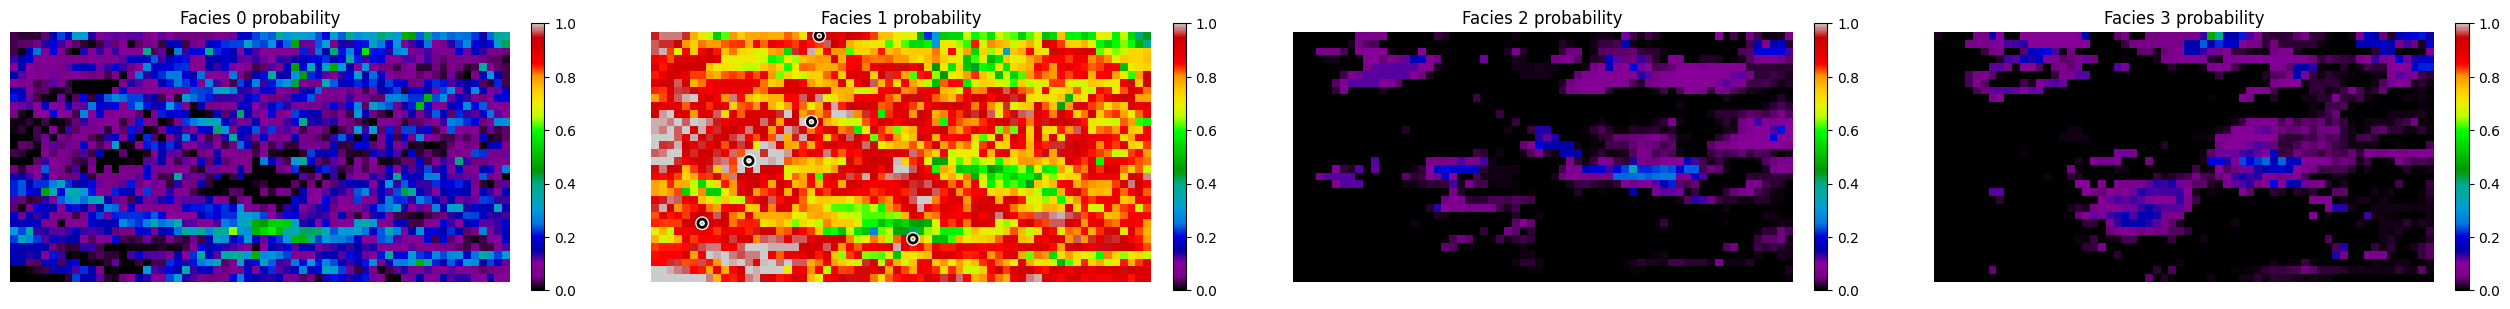

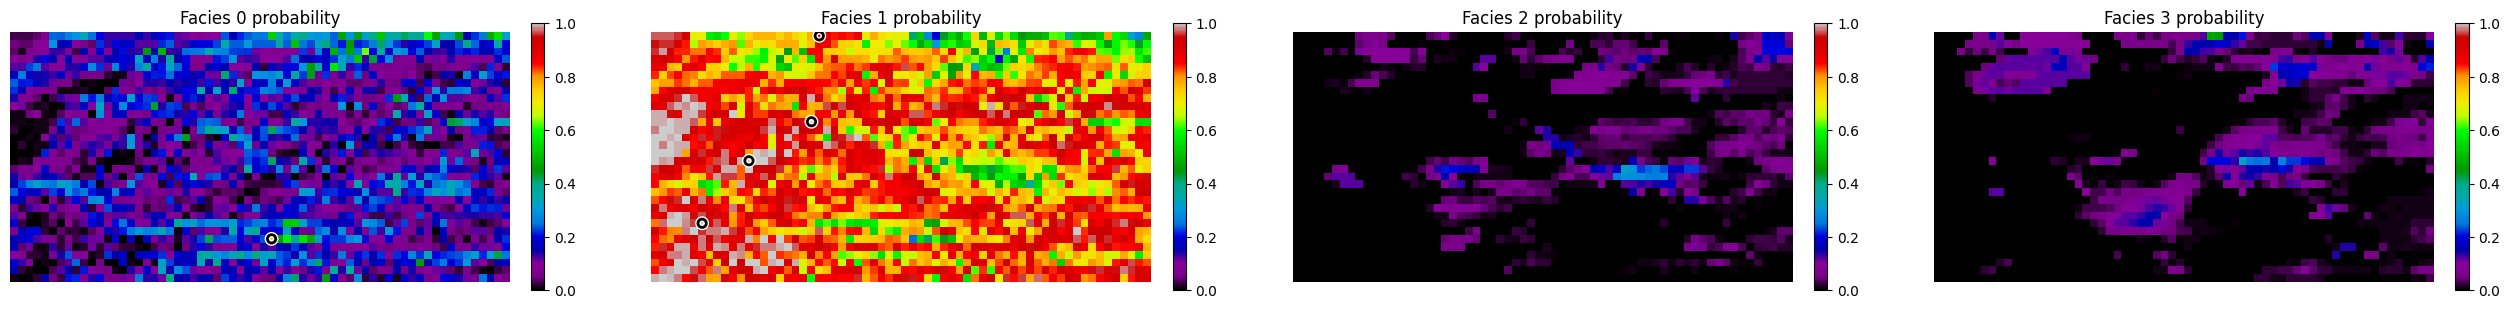

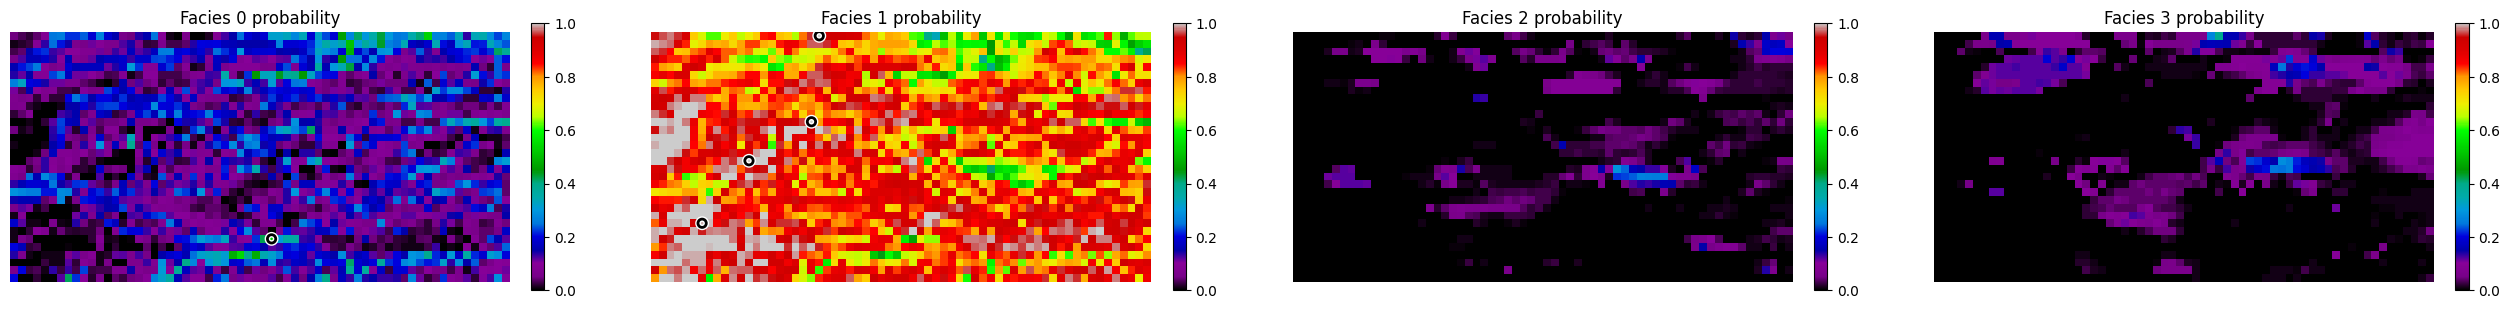

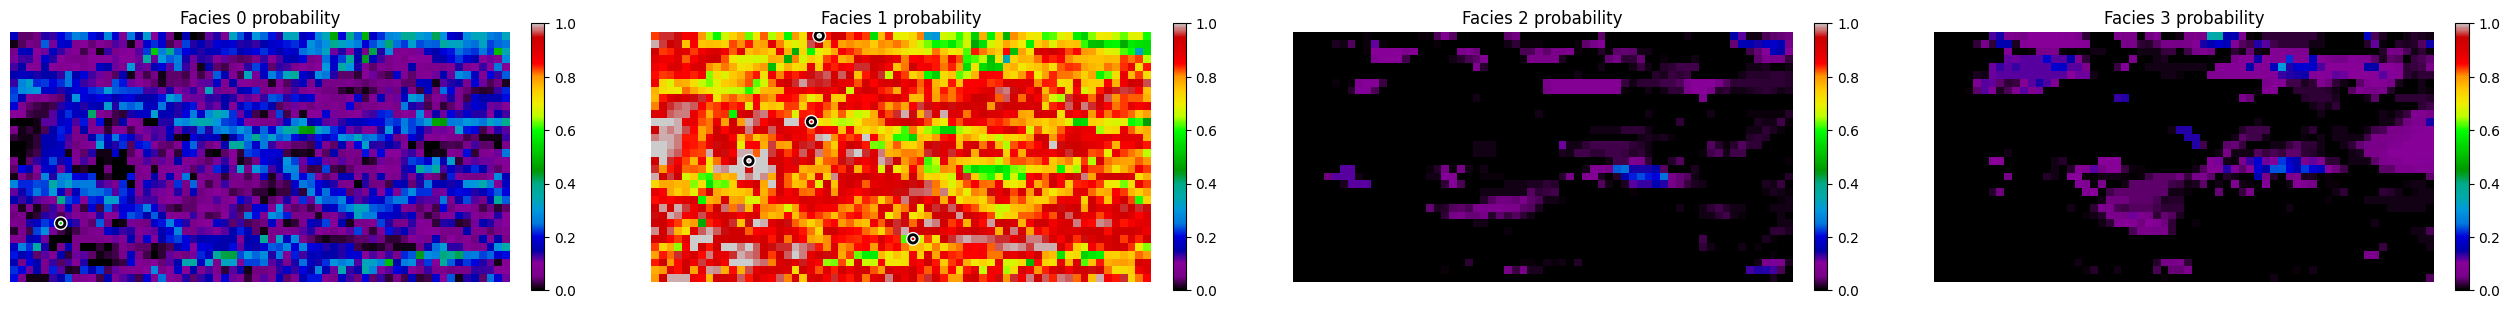

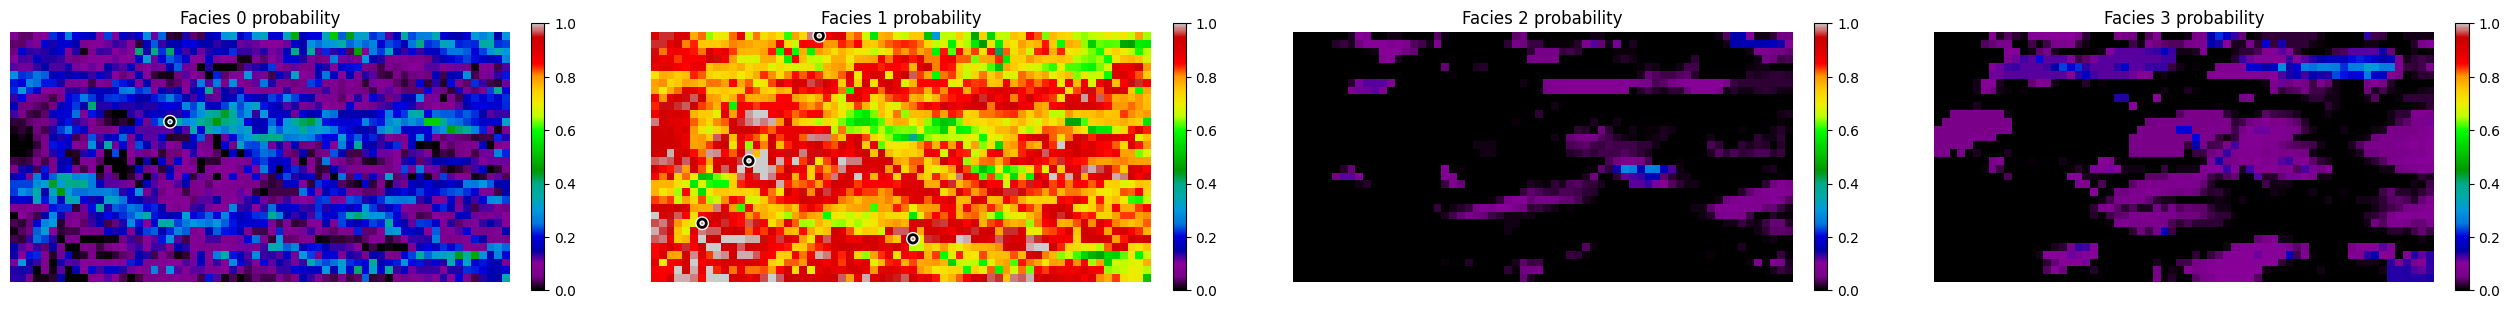

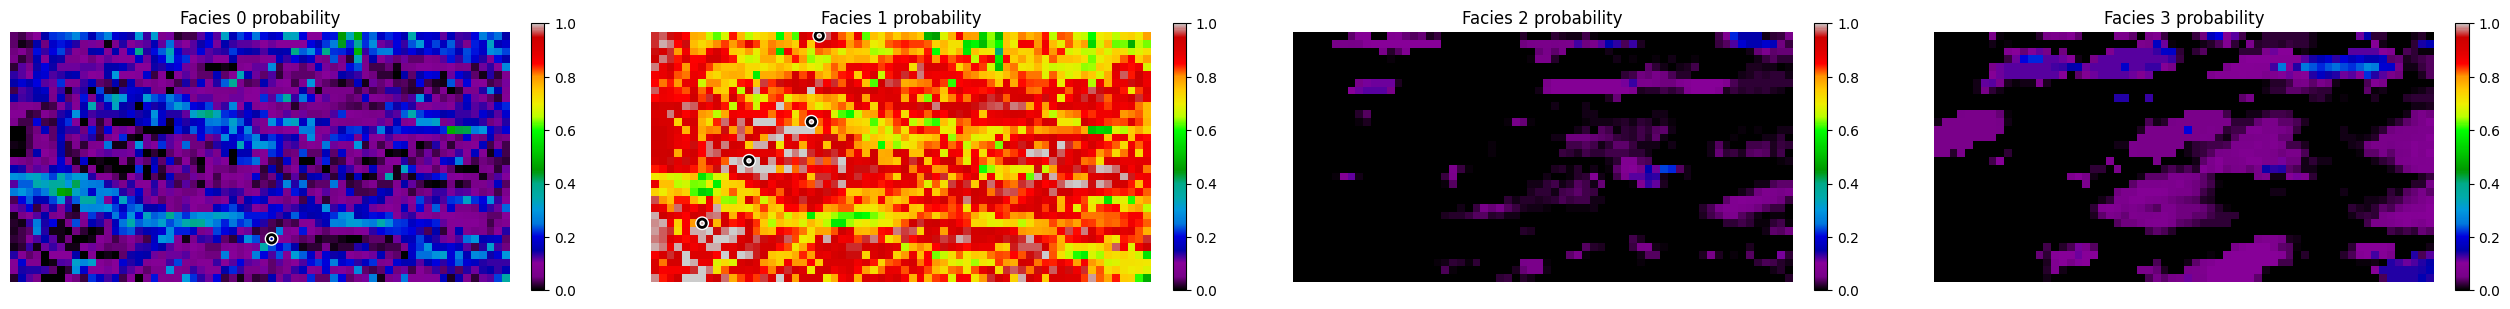

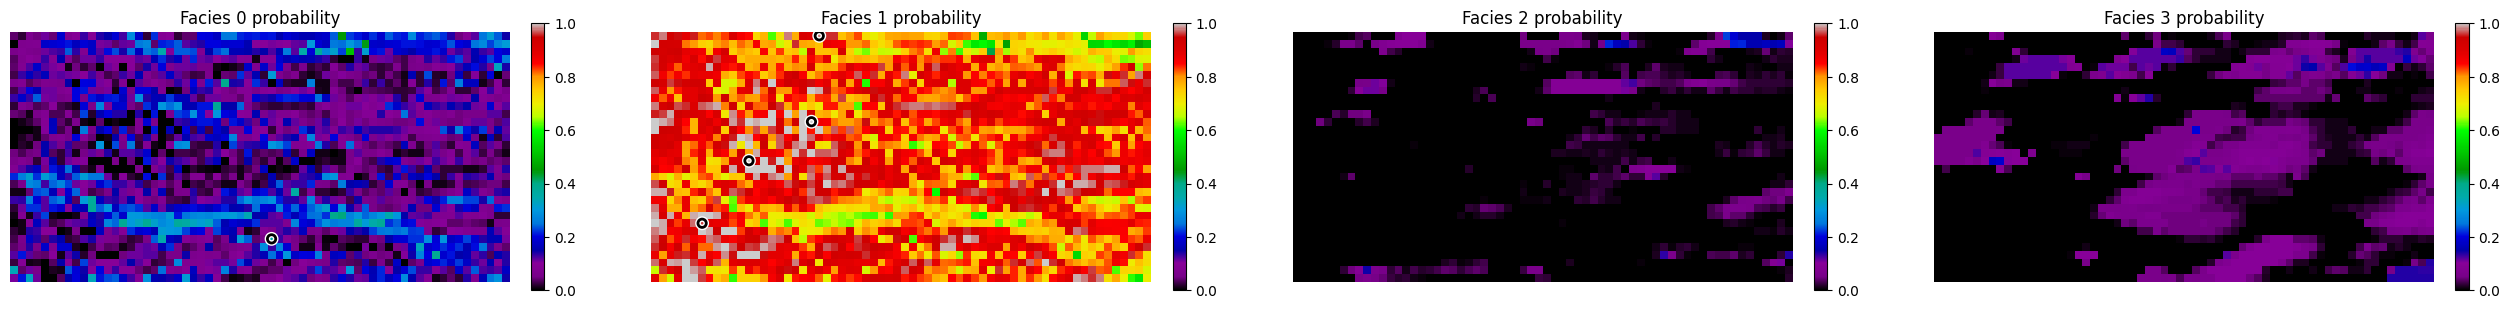

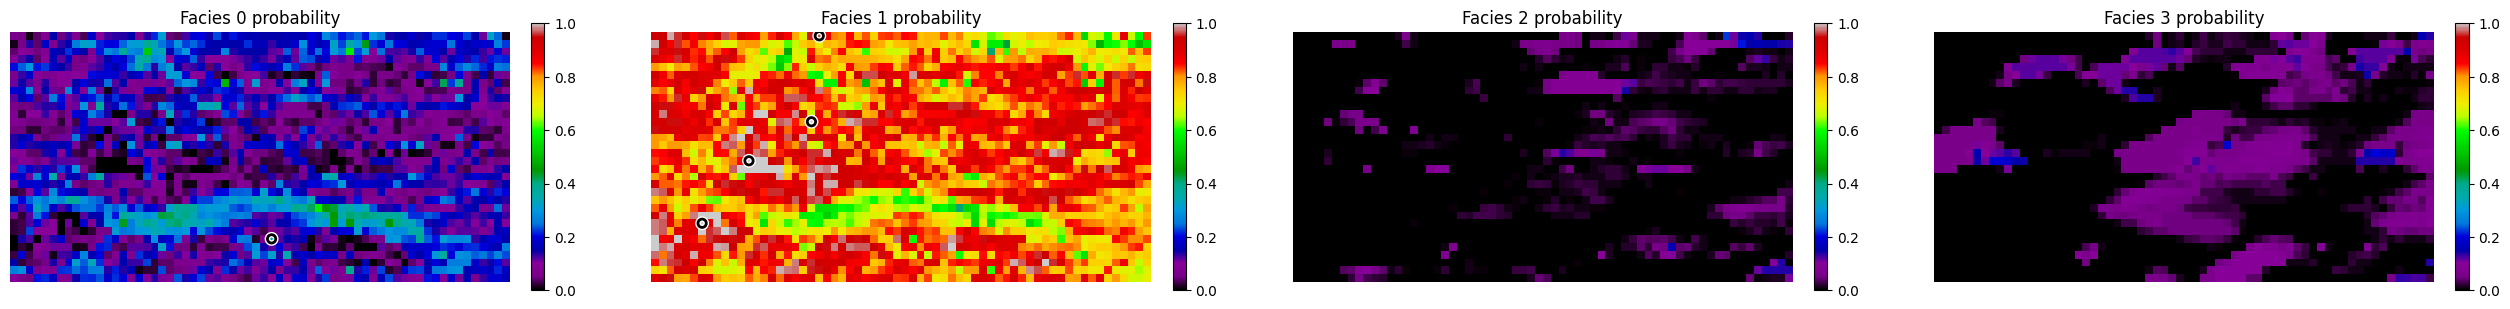

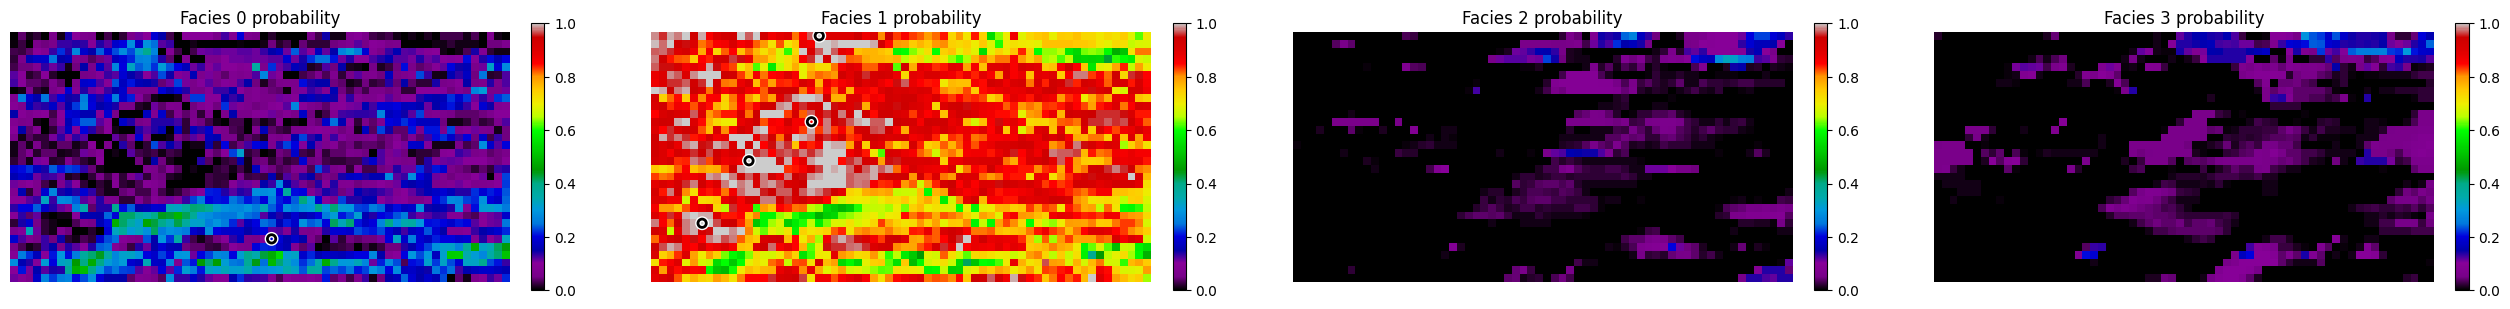

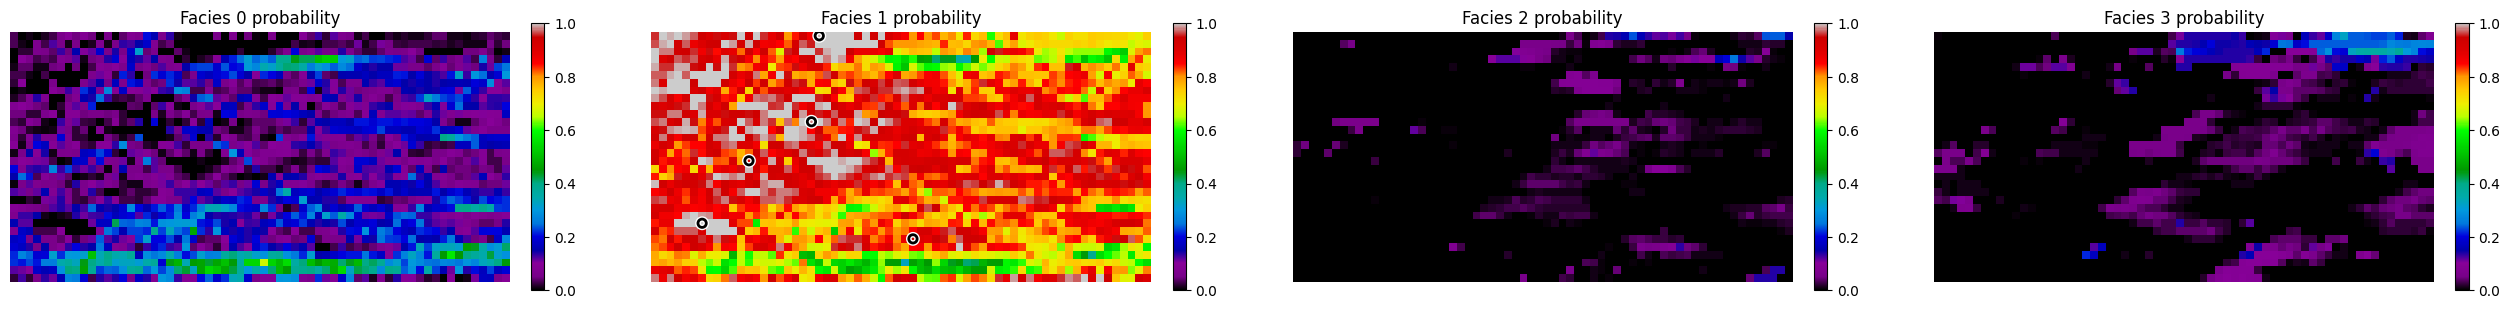

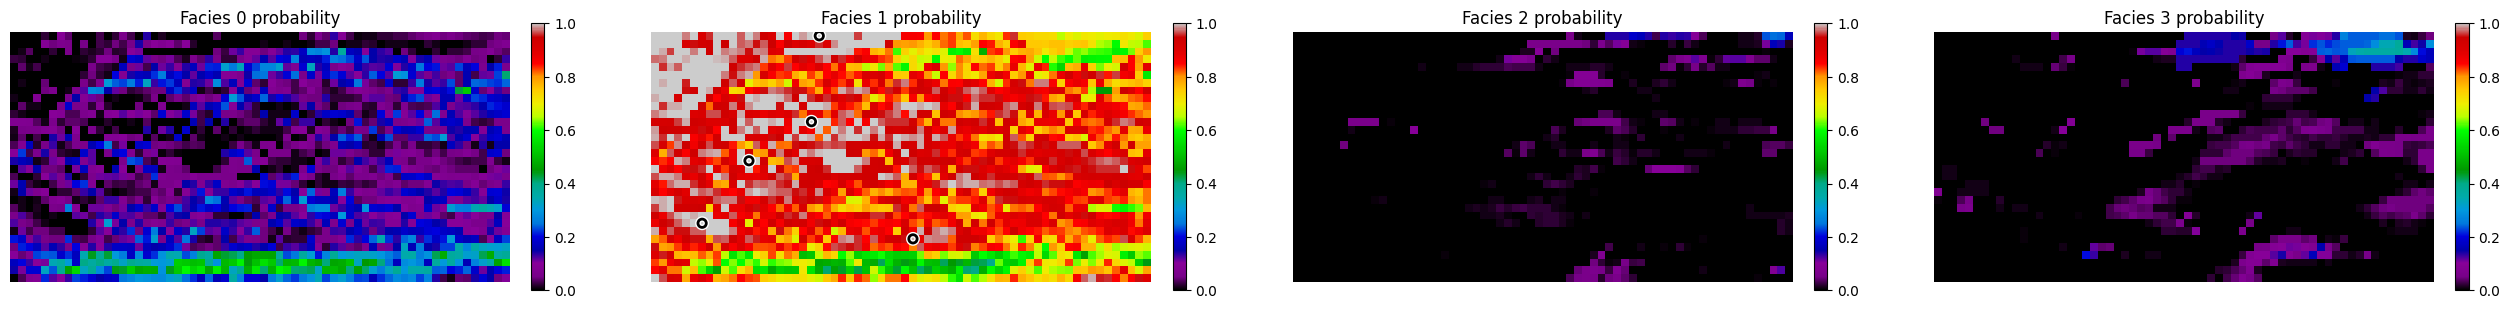

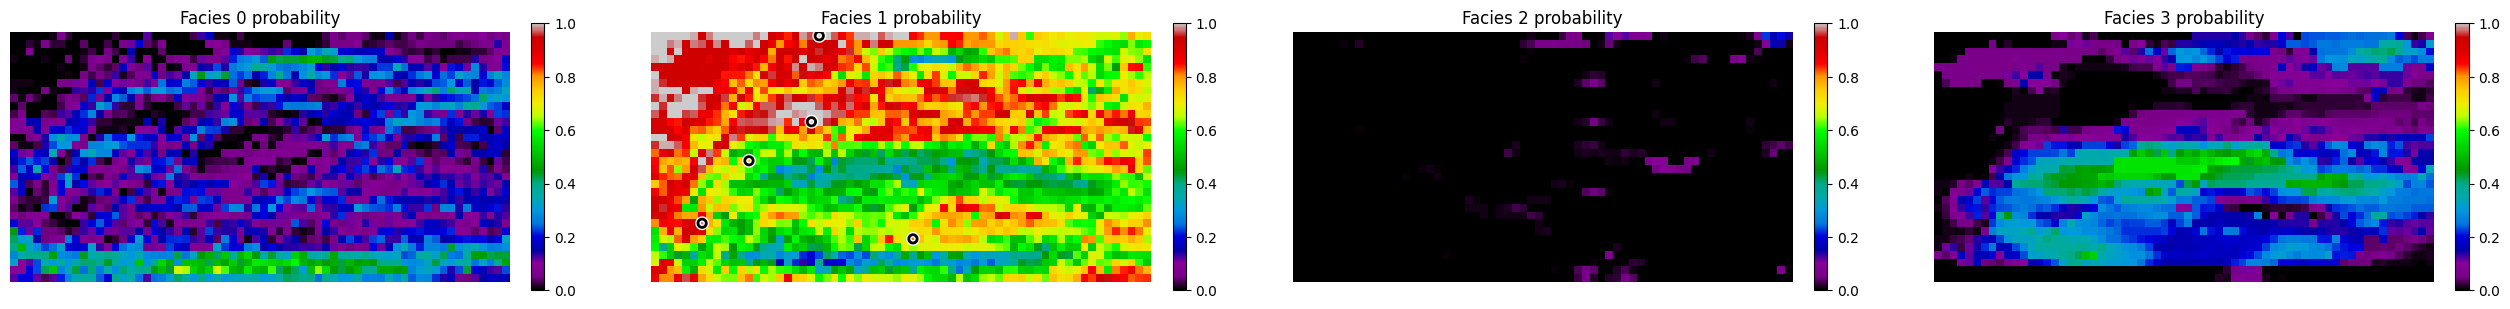

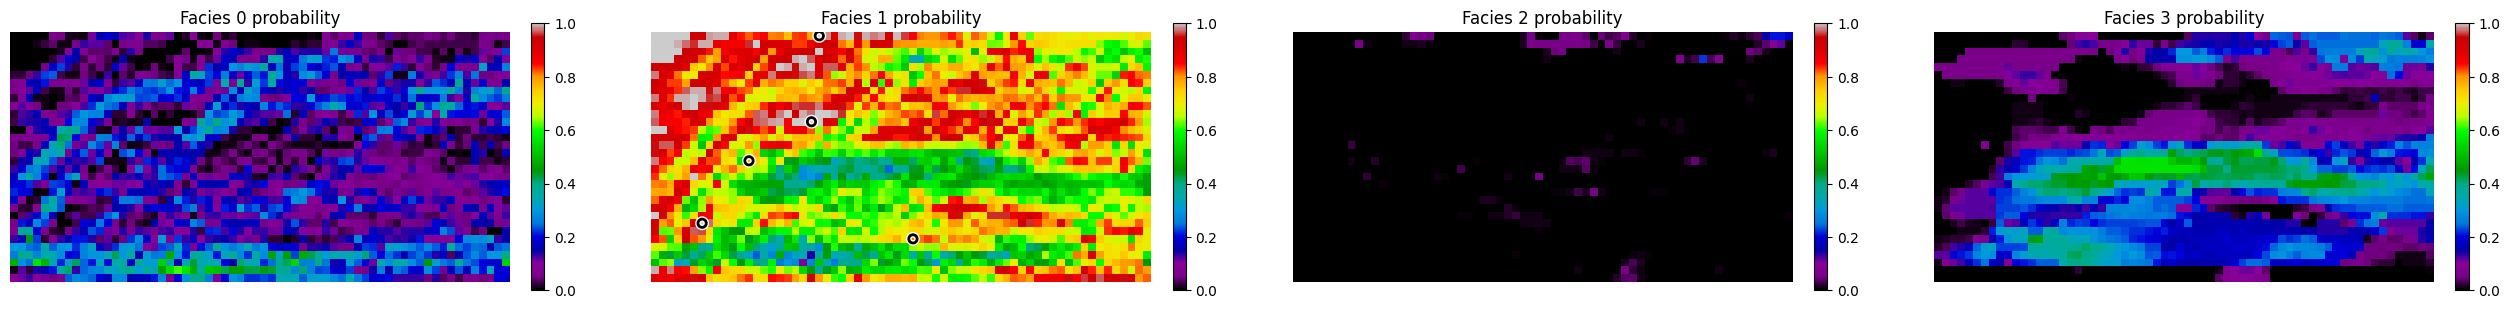

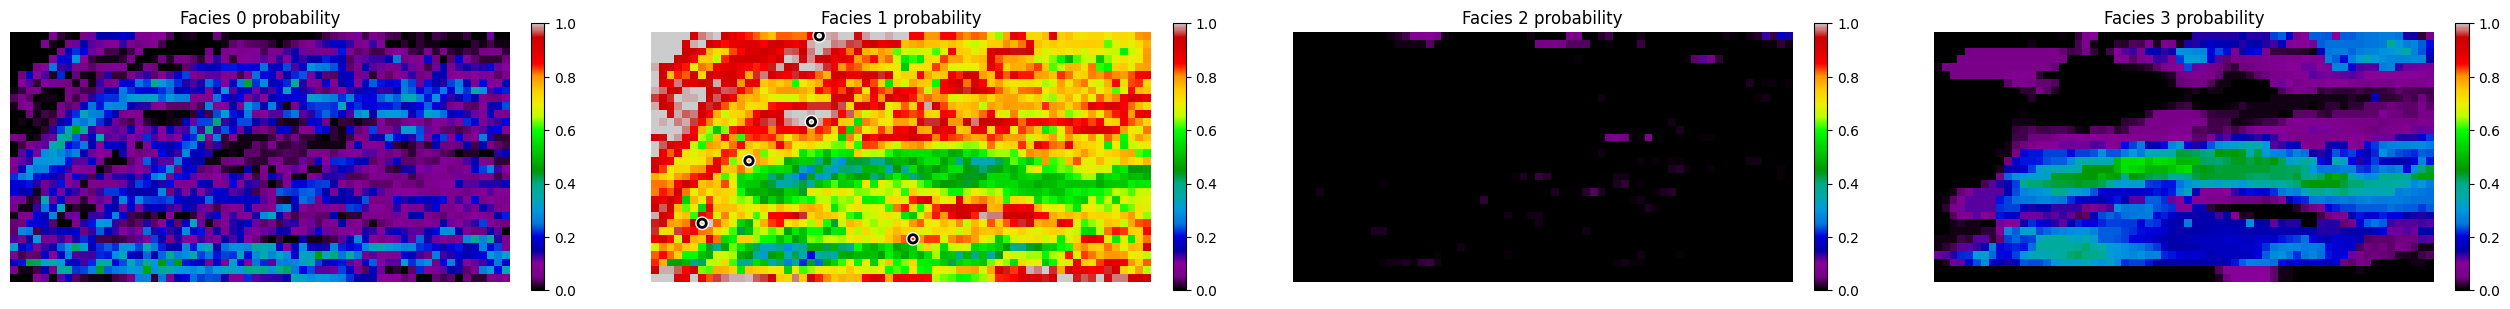

In [23]:
for i in range(16):
  generated_images_slice = generated_images[:, i]
  proba_map, most_probable_facies = compute_probability_map(generated_images_slice)
  real_proba_map, real_most_probable_facies = compute_probability_map(y)

  mski = np.expand_dims(msk[0, i], axis=0)
  xi = np.expand_dims(x[0, i], axis=0)
  #print_conditioned_results(xi, generated_images, mski, 4, cmap, norm, slice_size=(32, 64))
  #visualise_slice(generated_images_i, cmap, norm, 32, 64)
  print_proba_map(proba_map, cmap, norm, samples=xi)

(80,) (80,)
[100.    93.75  93.75  93.75  93.75  93.75  87.5   93.75  93.75  87.5
  93.75 100.    93.75  93.75  93.75  93.75 100.    93.75  93.75  87.5
  87.5   87.5   93.75  93.75  93.75  87.5   93.75  87.5   93.75  93.75
  87.5   93.75  93.75 100.    93.75  93.75  87.5   93.75  93.75  93.75
  93.75 100.    93.75  93.75  87.5   93.75  93.75  87.5   93.75  87.5
 100.    87.5   87.5  100.    87.5   93.75  93.75 100.    93.75  93.75
  87.5   93.75  93.75  93.75  93.75  93.75  93.75  93.75  93.75  93.75
  93.75  93.75  93.75  93.75  93.75  93.75  93.75  93.75  87.5   93.75
  93.75  93.75  87.5   93.75  93.75 100.    93.75  93.75 100.    93.75
 100.   100.    93.75  87.5   93.75  93.75  93.75 100.    93.75  93.75] 

[ 75.    75.    75.    87.5   75.    75.    56.25  75.    43.75  56.25
  81.25  68.75  62.5   87.5  100.    75.    68.75  75.    62.5   56.25
  56.25  56.25 100.    62.5   68.75  93.75  75.    56.25  87.5   75.
  81.25  75.    56.25  56.25  75.    75.    68.75  87.5   75.    75

<Axes: title={'center': 'Percentage of success in the each conditioning wells'}>

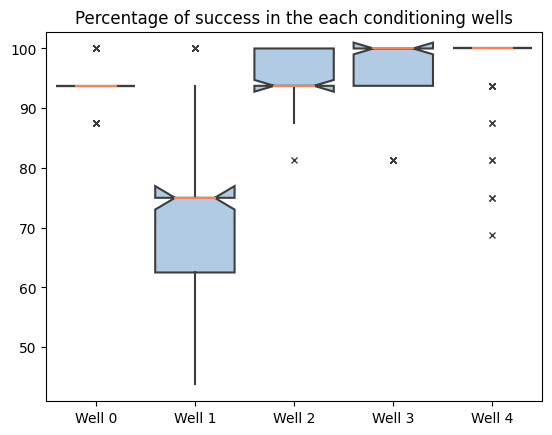

In [30]:
_, z_cond_pxl, x_cond_pxl, y_cond_pxl, _ = np.nonzero(msk)
print(x_cond_pxl.shape, y_cond_pxl.shape)
wells_xy_coordinates = list(set(list(zip(x_cond_pxl, y_cond_pxl))))
wells_xy_coordinates



wells_percentage_successes = {}

for i, coords_xy in enumerate(wells_xy_coordinates):
    x_coord, y_coord = coords_xy
    img_interpolated1 = np.argmax(generated_images, axis=-1).reshape((-1, 16, 32, 64))
    img_interpolated2 = np.argmax(x, axis=-1).reshape((-1, 16, 32, 64))
    tmp = (img_interpolated1[:, :, x_coord, y_coord] == np.squeeze(img_interpolated2[:, :, x_coord, y_coord])).astype(int)

    percentage_success = (np.mean(tmp, axis=-1) * 100)
    #wells_percentage_successes.append(np.array(percentage_success))
    wells_percentage_successes['Well {}'.format(i)] = np.array(percentage_success)
    print(percentage_success, '\n')

wells_percentage_successes = pd.DataFrame.from_dict(wells_percentage_successes)


all_arr = [np.random.uniform(size=20),
           np.random.uniform(size=20),
           np.random.uniform(size=20),
           np.random.uniform(size=20),
           np.random.uniform(size=20)]

import seaborn as sns

plt.title("Percentage of success in the each conditioning wells")
sns.boxplot(data=wells_percentage_successes, dodge=False,    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)